<a href="https://colab.research.google.com/github/fezilemahlangu/Natural-Language-Processing-Project/blob/main/NLP_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Fezile Mahlangu 

#2089676

#NLP Project 2022 


---

Project: Spam Classification Using Naive Bayes

Aim: Train and optimize a spam classifier using Naive Bayes classification model

Tasks:
- [x] Implement a Naive Bayes Model
- [x] Investigate the effect of using different features 
- [x] Evaluate the performance of different models
- [x] Optimize the model for better performance






---



# Imports

In [81]:
import numpy as np
import pandas as pd
import nltk
import copy
nltk.download('stopwords')
from nltk.tokenize import word_tokenize, wordpunct_tokenize
nltk.download("wordnet")
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import RegexpTokenizer
nltk.download('omw-1.4')

from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix,f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from collections import Counter
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Loading data

In [2]:
#loading data -> Remember to remove drive path and use normal path

train_df = pd.read_csv("/content/drive/MyDrive/NLP/train.csv")
val_df = pd.read_csv("/content/drive/MyDrive/NLP/val.csv")
test_df = pd.read_csv("/content/drive/MyDrive/NLP/test.csv")
display(train_df)

,text,label
0,"Subject: thank you\r\nami and daren , , , ,\r\...",0
1,"Subject: spot or firm tickets\r\nvance ,\r\nth...",0
2,Subject: software\r\nmicrosoft windows xp prof...,1
3,Subject: noms / actual flow for 2 / 27\r\nwe a...,0
4,Subject: superb so . ftware\r\nyoull discover ...,1
...,...,...
3097,Subject: \r\n( envelope - from 20040929124340 ...,1
3098,Subject: re : intraday eastrans nomination cha...,0
3099,Subject: meter 1601\r\ndaren - meter 1601 has ...,0
3100,Subject: need legal help ?\r\nto unsubscribe f...,1


Text(0, 0.5, 'number of records')

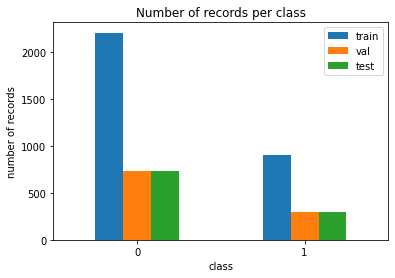

In [92]:

train = [train_df[train_df.label==0].count()[0],train_df[train_df.label==1].count()[0]]
test = [test_df[test_df.label==0].count()[0],test_df[test_df.label==1].count()[0]]
val = [val_df[val_df.label==0].count()[0],val_df[val_df.label==1].count()[0]]

index = ['0', '1']
df = pd.DataFrame({'train': train,
                   'val': val, 'test':test}, index=index)
ax = df.plot.bar(rot=0,title="Number of records per class")
ax.set_xlabel("class")
ax.set_ylabel("number of records")


# 1. Preprocessing of data

The text will be tokenized and there will be a list of words for each sentence 

In [ ]:
train_df.head()

,text,label
0,"Subject: thank you\r\nami and daren , , , ,\r\...",0
1,"Subject: spot or firm tickets\r\nvance ,\r\nth...",0
2,Subject: software\r\nmicrosoft windows xp prof...,1
3,Subject: noms / actual flow for 2 / 27\r\nwe a...,0
4,Subject: superb so . ftware\r\nyoull discover ...,1


In [8]:
#creating x and y arrays from dataframes 
train_x = train_df.text
train_y = train_df.label

test_x = test_df.text
test_y = test_df.label

val_x = val_df.text
val_y = val_df.label

len(train_x)

# https://www.kaggle.com/code/conniedeng/nlp-eron-dataset


3102

In [9]:
#turn into np arrays 
train_y = np.array(train_y)
val_y = np.array(val_y)
test_y = np.array(test_y)

In [10]:
def split_row(row):
  """
  Function takes in a row and splits by "\n"
  """
  return row.split("\n")

In [12]:
def tokenize(row):
  """
  splits by white space and punctuations
  """
  return wordpunct_tokenize(row)

In [13]:
def handle_money(row):
  #puts $5.99 back from ["$","5",".","99"]
  leng = len(row)
  i = 0
  while leng != 0 :
    if row[i]=='$' and row[i+2].isnumeric():
      row = row[:i+1] + row[(i+2):]
      leng-=1

    elif (row[i] == '.' and row[i+2].isnumeric() and row[i-2].isnumeric()):
      row = row[0:i-1] + row[i:i+1] + row[i+2:]
      leng-=2
    i+=1
    leng-=1

  return row
  

In [14]:
def remove_punct(row):
  """
  Goes through row and removes punctuation marks
  """

  return [word for word in row if word.isalpha()] 


In [15]:
stemmer = nltk.stem.porter.PorterStemmer()
def stem_words(row):
  """
  Function that performs stemming 
  removes word ending crudely -ing 
  """
  
  return [stemmer.stem(i) for i in row]


In [16]:
lemmatizer = nltk.stem.wordnet.WordNetLemmatizer()
def lemmatize(row):
  """
  performs lemmatization 
  make a word a root 
  """
 
  return [lemmatizer.lemmatize(i) for i in row]

In [19]:
#checking if functions work:

a = ["getting", "google", "meeting","rocks"]
print(a)
print(f"Stemming:{stem_words(a)}")
print(f"Lemmatization:{lemmatize(a)}")


['getting', 'google', 'meeting', 'rocks']
Stemming:['get', 'googl', 'meet', 'rock']
Lemmatization:['getting', 'google', 'meeting', 'rock']


In [20]:
tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')

def tokenize_with_money(row):
  '''
  splits by white space but doesnt split on money $
  '''
  return tokenizer.tokenize(row)


In [21]:
stop_words = nltk.corpus.stopwords.words('english')

def remove_stop_words(row):
  """
  Function that removes stop words -> really frequent words
  """
  return [i for i in row if i not in stop_words]

In [22]:
def clean_x(data):
  clean = []
  for i in data:
    text = tokenize_with_money(i)

    text = remove_punct(text)

    text = remove_stop_words(text)

    text = stem_words(text)

    text = lemmatize(text)

    clean.append(text)
  return clean 



In [23]:

clean_train_x = clean_x(train_x)
clean_val_x = clean_x(val_x)
clean_test_x = clean_x(test_x)


In [24]:
print("Text before preprocessing: \n")
print(train_x[0])
print("----------------------------------------------------------------------------------------------------------------------------------------------------------------------")
print("Text after preprocessing: \n")
print(clean_train_x[0])
print("----------------------------------------------------------------------------------------------------------------------------------------------------------------------")

Text before preprocessing: 

Subject: thank you
ami and daren , , , ,
just wanted again to say thanks ! ! ! , for the great time at st . pete ' s beach ,
fla .
the company , food , fishing and yes , of coarse
the drink or many drinks were great ! ! ! daren , can relate to the drinks .
i enjoyed meeting everyone there .
we appreciate your business and look forward to continue our business relation
with enron in the future .
sincerely ,
tim
----------------------------------------------------------------------------------------------------------------------------------------------------------------------
Text after preprocessing: 

['subject', 'thank', 'ami', 'daren', 'want', 'say', 'thank', 'great', 'time', 'st', 'pete', 'beach', 'fla', 'compani', 'food', 'fish', 'ye', 'coars', 'drink', 'mani', 'drink', 'great', 'daren', 'relat', 'drink', 'enjoy', 'meet', 'everyon', 'appreci', 'busi', 'look', 'forward', 'continu', 'busi', 'relat', 'enron', 'futur', 'sincer', 'tim']
---------------------

In [ ]:
print("Text before preprocessing: \n")
print(train_x[1])
print("----------------------------------------------------------------------------------------------------------------------------------------------------------------------")
print("Text after preprocessing: \n")
print(clean_train_x[2])
print("----------------------------------------------------------------------------------------------------------------------------------------------------------------------")

# 2. Training a standard Naive Bayes model 

In [25]:
from sklearn.pipeline import Pipeline
#creating a pipeline for each model 

pipeline1 = Pipeline([
   ('bow',CountVectorizer()),
    ('classifier',MultinomialNB()),
])

pipeline2 = Pipeline([
   ('bow',CountVectorizer()),
    ('classifier',MultinomialNB()),
])

pipeline3 = Pipeline([
   ('bow',CountVectorizer()),
    ('classifier',MultinomialNB()),
])

pipeline4 = Pipeline([
   ('bow',CountVectorizer()),
    ('classifier',MultinomialNB()),
])

pipeline4 = Pipeline([
   ('bow',CountVectorizer()),
    ('classifier',MultinomialNB()),
])

pipeline5 = Pipeline([
   ('bow',CountVectorizer()),
    ('classifier',MultinomialNB()),
])

In [ ]:
# #scale data ?

# from sklearn.preprocessing import StandardScaler

# sc = StandardScaler()

# x_train is after count_vector.fit 
# x_train = sc.fit_transform(x_train)
# x_test = sc.transform(x_test)

#LAPLACE SMOOTHING 

In [26]:
#transforming to numeric form for MultinomialNB

#old code 
    # count_vector = CountVectorizer()

    # clean_train_x_join = [" ".join(i) for i in clean_train_x] #turn to string for count_vector 


    # trans_x = count_vector.fit_transform(clean_train_x_join)

    # # trans_x_dense = np.array(trans_x.todense())

    # Model1 = MultinomialNB().fit(trans_x,train_y) #multi ???
#new code

clean_train_x_join = [" ".join(i) for i in clean_train_x] #turn to string for count_vector 
Model1 = pipeline1.fit(clean_train_x_join,train_y)



In [ ]:
# trans_x[0][0]
# https://www.kaggle.com/code/syamalakumar/spam-ham-nlp-basic-project

# https://www.kaggle.com/code/dilip990/spam-ham-detection-using-naive-bayes-classifier

# https://www.kaggle.com/code/conniedeng/nlp-eron-dataset


#https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html

# https://www.kdnuggets.com/2020/06/naive-bayes-algorithm-everything.html



## 3a. Naive Bayes model using 10 most frequent words as features 

In [27]:
#creating one big array from clean_train_x
all_clean_x = []
for arr in clean_train_x:
  for i in range(1,len(arr)): #doesnt include "subject" from subject lien 
      all_clean_x.append(arr[i])

In [28]:
print(all_clean_x[0:50]) #doesnt inlcude subject

['thank', 'ami', 'daren', 'want', 'say', 'thank', 'great', 'time', 'st', 'pete', 'beach', 'fla', 'compani', 'food', 'fish', 'ye', 'coars', 'drink', 'mani', 'drink', 'great', 'daren', 'relat', 'drink', 'enjoy', 'meet', 'everyon', 'appreci', 'busi', 'look', 'forward', 'continu', 'busi', 'relat', 'enron', 'futur', 'sincer', 'tim', 'spot', 'firm', 'ticket', 'vanc', 'follow', 'nomin', 'deal', 'ticket', 'sitara', 'septemb', 'activ', 'plea']


In [29]:
#get top 10 features using Counter 
Counter = Counter(all_clean_x)

top10 = Counter.most_common(10)

print("The top 10 features are:")
print(top10)
  
# print(most_occur)

[('ect', 8343), ('hou', 4376), ('enron', 3908), ('com', 2452), ('deal', 2200), ('plea', 1892), ('ga', 1794), ('subject', 1674), ('meter', 1569), ('hpl', 1404)]


In [30]:
#extracting words from "top10" given by Counter.most_common
top_10_dictionary=[]
for i in top10:
  top_10_dictionary.append(i[0])
print(top_10_dictionary)


['ect', 'hou', 'enron', 'com', 'deal', 'plea', 'ga', 'subject', 'meter', 'hpl']


In [31]:
top10_train_x = []
# top10_train_x[0]
for arr in clean_train_x:
  new_arr = []
  for word in arr:
    if word in top_10_dictionary:
      new_arr.append(word)
  top10_train_x.append(new_arr)




In [32]:
try:
  len(clean_train_x) == len(top10_train_x)
except:
  print("lengths do not match ")

In [33]:
print("First element clean:")
print(clean_train_x[0])
print("First element with top 10 features:")
print(top10_train_x[0])
print("--------------------------------------------------------------------")
print("Second element clean:")
print(clean_train_x[1])
print("Second element with top 10 features:")
print(top10_train_x[1])
print("--------------------------------------------------------------------")
print("Third element clean:")
print(clean_train_x[2])
print("Third element with top 10 features:")
print(top10_train_x[2])

First element clean:
['subject', 'thank', 'ami', 'daren', 'want', 'say', 'thank', 'great', 'time', 'st', 'pete', 'beach', 'fla', 'compani', 'food', 'fish', 'ye', 'coars', 'drink', 'mani', 'drink', 'great', 'daren', 'relat', 'drink', 'enjoy', 'meet', 'everyon', 'appreci', 'busi', 'look', 'forward', 'continu', 'busi', 'relat', 'enron', 'futur', 'sincer', 'tim']
First element with top 10 features:
['subject', 'enron']
--------------------------------------------------------------------
Second element clean:
['subject', 'spot', 'firm', 'ticket', 'vanc', 'follow', 'nomin', 'deal', 'ticket', 'sitara', 'septemb', 'activ', 'plea', 'advis', 'whether', 'deal', 'spot', 'firm', 'daren', 'want', 'everyth', 'sitara', 'pm', 'monday', 'august', 'thank', 'bob', 'sourc', 'meter', 'sept', 'nom', 'ccgm', 'lp', 'cross', 'tex', 'cummin', 'walker', 'unk', 'dalla', 'product', 'duke', 'energi', 'trade', 'eex', 'oper', 'eog', 'resourc', 'hesco', 'gather', 'hesco', 'gather', 'ph', 'explor', 'pioneer', 'explor', 

In [ ]:
# #Naive base model 
# count_vector = CountVectorizer()

# top10_train_x_join = [" ".join(i) for i in top10_train_x] #turn to string for count_vector 

# trans_x = count_vector.fit_transform(top10_train_x_join)

# trans_x_dense = np.array(trans_x.todense())

# Model2 = MultinomialNB().fit(trans_x_dense,train_y) #multi ???

In [34]:
top10_train_x_join = [" ".join(i) for i in top10_train_x] #turn to string for count_vector 
Model2 = pipeline2.fit(top10_train_x_join,train_y) #fit 

## 3b. Naive Bayes model using 100 most frequent words as features 

In [35]:


# Counter = Counter(all_clean_x)

top100 = Counter.most_common(100)

print("The top 100 features are:")
print(top100)

top_100_dictionary=[]
for i in top100:
  top_100_dictionary.append(i[0])
print(top_100_dictionary)

[('ect', 8343), ('hou', 4376), ('enron', 3908), ('com', 2452), ('deal', 2200), ('plea', 1892), ('ga', 1794), ('subject', 1674), ('meter', 1569), ('hpl', 1404), ('cc', 1392), ('thank', 1348), ('pm', 1331), ('need', 1249), ('e', 1203), ('daren', 1120), ('forward', 1091), ('price', 1089), ('volum', 1040), ('corp', 1030), ('know', 976), ('day', 950), ('new', 898), ('get', 892), ('compani', 873), ('j', 813), ('may', 806), ('mmbtu', 802), ('product', 800), ('chang', 788), ('see', 771), ('u', 766), ('l', 763), ('http', 756), ('contract', 751), ('inform', 737), ('attach', 713), ('let', 692), ('nom', 676), ('time', 673), ('farmer', 665), ('xl', 658), ('month', 653), ('would', 641), ('sale', 639), ('nomin', 632), ('messag', 618), ('mail', 607), ('one', 603), ('th', 594), ('call', 578), ('flow', 572), ('juli', 571), ('follow', 563), ('use', 561), ('robert', 556), ('question', 551), ('email', 517), ('ticket', 516), ('file', 515), ('net', 515), ('p', 512), ('report', 503), ('want', 500), ('look', 4

In [36]:
top100_train_x = []
# top10_train_x[0]
for arr in clean_train_x:
  new_arr = []
  for word in arr:
    if word in top_100_dictionary:
      new_arr.append(word)
  top100_train_x.append(new_arr)

In [37]:
try:
  len(clean_train_x) == len(top100_train_x)
except:
  print("lengths do not match ")

In [38]:
print("First element clean:")
print(clean_train_x[0])
print("First element with top 100 features:")
print(top100_train_x[0])
print("--------------------------------------------------------------------")
print("Second element clean:")
print(clean_train_x[1])
print("Second element with top 100 features:")
print(top100_train_x[1])
print("--------------------------------------------------------------------")
print("Third element clean:")
print(clean_train_x[2])
print("Third element with top 100 features:")
print(top100_train_x[2])

First element clean:
['subject', 'thank', 'ami', 'daren', 'want', 'say', 'thank', 'great', 'time', 'st', 'pete', 'beach', 'fla', 'compani', 'food', 'fish', 'ye', 'coars', 'drink', 'mani', 'drink', 'great', 'daren', 'relat', 'drink', 'enjoy', 'meet', 'everyon', 'appreci', 'busi', 'look', 'forward', 'continu', 'busi', 'relat', 'enron', 'futur', 'sincer', 'tim']
First element with top 100 features:
['subject', 'thank', 'daren', 'want', 'thank', 'time', 'compani', 'daren', 'busi', 'look', 'forward', 'busi', 'enron']
--------------------------------------------------------------------
Second element clean:
['subject', 'spot', 'firm', 'ticket', 'vanc', 'follow', 'nomin', 'deal', 'ticket', 'sitara', 'septemb', 'activ', 'plea', 'advis', 'whether', 'deal', 'spot', 'firm', 'daren', 'want', 'everyth', 'sitara', 'pm', 'monday', 'august', 'thank', 'bob', 'sourc', 'meter', 'sept', 'nom', 'ccgm', 'lp', 'cross', 'tex', 'cummin', 'walker', 'unk', 'dalla', 'product', 'duke', 'energi', 'trade', 'eex', 'o

In [ ]:
# #Naive base model 
# count_vector = CountVectorizer()

# top100_train_x_join = [" ".join(i) for i in top100_train_x] #turn to string for count_vector 

# trans_x = count_vector.fit_transform(top100_train_x_join)

# trans_x_dense = np.array(trans_x.todense())

# Model3 = MultinomialNB().fit(trans_x_dense,train_y) #multi ???

In [39]:
top100_train_x_join = [" ".join(i) for i in top100_train_x] #turn to string for count_vector 
Model3 = pipeline3.fit(top100_train_x_join,train_y) #fit

## 3c. Naive Bayes model removing 100 most frequent words from features 

In [40]:
not_top100_train_x = []

for arr in clean_train_x:
  new_arr = []
  for word in arr:
    if word not in top_100_dictionary:
      new_arr.append(word)
  not_top100_train_x.append(new_arr)

In [41]:
try:
  len(clean_train_x) == len(not_top100_train_x)
except:
  print("lengths do not match ")

print("First element clean:")
print(clean_train_x[0])
print("First element with top 100 features removed:")
print(not_top100_train_x[0])
print("--------------------------------------------------------------------")
print("Second element clean:")
print(clean_train_x[1])
print("Second element with top 100 features removed:")
print(not_top100_train_x[1])
print("--------------------------------------------------------------------")
print("Third element clean:")
print(clean_train_x[2])
print("Third element with top 100 features removed:")
print(not_top100_train_x[2])

First element clean:
['subject', 'thank', 'ami', 'daren', 'want', 'say', 'thank', 'great', 'time', 'st', 'pete', 'beach', 'fla', 'compani', 'food', 'fish', 'ye', 'coars', 'drink', 'mani', 'drink', 'great', 'daren', 'relat', 'drink', 'enjoy', 'meet', 'everyon', 'appreci', 'busi', 'look', 'forward', 'continu', 'busi', 'relat', 'enron', 'futur', 'sincer', 'tim']
First element with top 100 features removed:
['ami', 'say', 'great', 'st', 'pete', 'beach', 'fla', 'food', 'fish', 'ye', 'coars', 'drink', 'mani', 'drink', 'great', 'relat', 'drink', 'enjoy', 'meet', 'everyon', 'appreci', 'continu', 'relat', 'futur', 'sincer', 'tim']
--------------------------------------------------------------------
Second element clean:
['subject', 'spot', 'firm', 'ticket', 'vanc', 'follow', 'nomin', 'deal', 'ticket', 'sitara', 'septemb', 'activ', 'plea', 'advis', 'whether', 'deal', 'spot', 'firm', 'daren', 'want', 'everyth', 'sitara', 'pm', 'monday', 'august', 'thank', 'bob', 'sourc', 'meter', 'sept', 'nom', '

In [ ]:
# #Naive base model 
# count_vector = CountVectorizer()

# not_top100_train_x_join = [" ".join(i) for i in not_top100_train_x] #turn to string for count_vector 

# trans_x = count_vector.fit_transform(not_top100_train_x_join)

# trans_x_dense = np.array(trans_x.todense())

# Model4 = MultinomialNB().fit(trans_x_dense,train_y) #multi ???

In [42]:
not_top100_train_x_join = [" ".join(i) for i in not_top100_train_x] #turn to string for count_vector 
Model4 = pipeline4.fit(not_top100_train_x_join,train_y) #fit 

## 3d. Naive Bayes model using subject line as the feature set

In [43]:
# def get_body(data):
#   return data[data.find('\r\n')+2:]

def get_subject(data):
  '''
  extracts subject line from each email 
  '''
  subject = data[0:data.find('\r\n')]
  return subject.replace("Subject: ","")

In [44]:
train_df.head()

,text,label
0,"Subject: thank you\r\nami and daren , , , ,\r\...",0
1,"Subject: spot or firm tickets\r\nvance ,\r\nth...",0
2,Subject: software\r\nmicrosoft windows xp prof...,1
3,Subject: noms / actual flow for 2 / 27\r\nwe a...,0
4,Subject: superb so . ftware\r\nyoull discover ...,1


In [45]:
train_df["subject"] = train_df["text"].apply(lambda x: get_subject(x))
train_df.head()

,text,label,subject
0,"Subject: thank you\r\nami and daren , , , ,\r\...",0,thank you
1,"Subject: spot or firm tickets\r\nvance ,\r\nth...",0,spot or firm tickets
2,Subject: software\r\nmicrosoft windows xp prof...,1,software
3,Subject: noms / actual flow for 2 / 27\r\nwe a...,0,noms / actual flow for 2 / 27
4,Subject: superb so . ftware\r\nyoull discover ...,1,superb so . ftware


In [46]:
train_x_subject = train_df.subject
clean_train_x_subject = clean_x(train_x_subject)

In [ ]:



# count_vector = CountVectorizer()

# clean_train_x_subject_join = [" ".join(i) for i in clean_train_x_subject] #turn to string for count_vector 


# trans_x = count_vector.fit_transform(clean_train_x_subject_join)

# trans_x_dense = np.array(trans_x.todense())

# Model5 = MultinomialNB().fit(trans_x_dense,train_y) #multi ???

In [47]:
clean_train_x_subject_join = [" ".join(i) for i in clean_train_x_subject] #turn to string for count_vector 
Model5 = pipeline5.fit(clean_train_x_subject_join,train_y) #fit



---



---


# 4. Evaluation using validation set

## 4a. Calculating the evaluation metrics

The metrics that will be used are : model accuracy, f1 score, precision, recall 

In [48]:
# count_vector = CountVectorizer()

clean_val_x_join = [" ".join(i) for i in clean_val_x] #turn to string for count_vector 

# trans_x = count_vector.fit_transform(clean_val_x_join)

# val_x_dense = np.array(trans_x.todense())


In [49]:
# model accuracy, 
def get_model_accuracy(Model):
  predicted = Model.predict(clean_val_x_join)
  return accuracy_score(val_y,predicted)*100

#f1 score 
# def get_f1(Model):

# def get_precision(Model):

# def get_recall(Model):

def report(Model):
  predicted = Model.predict(clean_val_x_join)
  return classification_report(predicted,val_y), classification_report(predicted,val_y,output_dict=True)

In [50]:
# print(f"Model 1 accuracy: {round(get_model_accuracy(Model1),2)} %")
print("Model 1")
report1,dict1 = report(Model1)
print(report1)

# print(f"Model 2 accuracy: {round(get_model_accuracy(Model2),2)} %")
print("Model 2")
report2,dict2 = report(Model2)
print(report2)

# print(f"Model 3 accuracy: {round(get_model_accuracy(Model3),2)} %")
print("Model 3")
report3,dict3= report(Model3)
print(report3)
# print(f"Model 4 accuracy: {round(get_model_accuracy(Model4),2)} %")
print("Model 4")
# report(Model4)
report4,dict4 = report(Model4)
print(report4)
# print(f"Model 5 accuracy: {round(get_model_accuracy(Model5),2)} %")
print("Model 5")
report5,dict5 = report(Model5)
print(report5)

Model 1
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       740
           1       0.94      0.95      0.94       295

    accuracy                           0.97      1035
   macro avg       0.96      0.96      0.96      1035
weighted avg       0.97      0.97      0.97      1035

Model 2
              precision    recall  f1-score   support

           0       0.73      0.98      0.84       549
           1       0.96      0.59      0.74       486

    accuracy                           0.80      1035
   macro avg       0.85      0.79      0.79      1035
weighted avg       0.84      0.80      0.79      1035

Model 3
              precision    recall  f1-score   support

           0       0.87      0.93      0.90       690
           1       0.83      0.72      0.77       345

    accuracy                           0.86      1035
   macro avg       0.85      0.82      0.83      1035
weighted avg       0.86      0.86      0.86      1

## 4b. Comparing all 5 models 

In [51]:
M1 = [dict1["accuracy"],dict1['0']['f1-score'],dict1['1']['f1-score'],dict1['0']['precision'],dict1['1']['precision'],dict1['0']['recall'],dict1['1']['recall']]
M2 = [dict2["accuracy"],dict2['0']['f1-score'],dict2['1']['f1-score'],dict2['0']['precision'],dict2['1']['precision'],dict2['0']['recall'],dict2['1']['recall']]
M3 = [dict3["accuracy"],dict3['0']['f1-score'],dict3['1']['f1-score'],dict3['0']['precision'],dict3['1']['precision'],dict3['0']['recall'],dict3['1']['recall']]
M4 = [dict4["accuracy"],dict4['0']['f1-score'],dict4['1']['f1-score'],dict4['0']['precision'],dict4['1']['precision'],dict4['0']['recall'],dict4['1']['recall']]
M5 = [dict5["accuracy"],dict5['0']['f1-score'],dict5['1']['f1-score'],dict5['0']['precision'],dict5['1']['precision'],dict5['0']['recall'],dict5['1']['recall']]


index = ['acc', 'f1_0','f1_1', 'precision_0','precision_1', 'recall_0','recall_1']
df = pd.DataFrame({'Model1': M1,
                   'Model2': M2, 'Model3':M3, 'Model4':M4, 'Model5':M5}, index=index)
df
# ax = df.plot.bar(rot=0)

,Model1,Model2,Model3,Model4,Model5
acc,0.968116,0.799034,0.857971,0.969082,0.911111
f1_0,0.977627,0.838006,0.896842,0.978552,0.935028
f1_1,0.944538,0.735369,0.772093,0.944637,0.859327
precision_0,0.980952,0.731973,0.869388,0.993197,0.900680
precision_1,0.936667,0.963333,0.830000,0.910000,0.936667
recall_0,0.974324,0.979964,0.926087,0.964333,0.972100
recall_1,0.952542,0.594650,0.721739,0.982014,0.793785


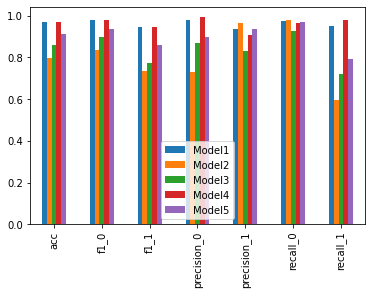

In [52]:
ax = df.plot.bar()

In [53]:
acc = [dict1["accuracy"],dict2["accuracy"],dict3["accuracy"],dict4["accuracy"],dict5["accuracy"]]
f1_0 = [dict1['0']['f1-score'],dict2['0']['f1-score'],dict3['0']['f1-score'],dict4['0']['f1-score'],dict5['0']['f1-score']]
f1_1 = [dict1['1']['f1-score'],dict2['1']['f1-score'],dict3['1']['f1-score'],dict4['1']['f1-score'],dict5['1']['f1-score']]
precision_0 = [dict1['0']['precision'],dict2['0']['precision'],dict3['0']['precision'],dict4['0']['precision'],dict5['0']['precision']]
precision_1 = [dict1['1']['precision'],dict2['1']['precision'],dict3['1']['precision'],dict4['1']['precision'],dict5['1']['precision']]
recall_0 = [dict1['0']['recall'],dict2['0']['recall'],dict3['0']['recall'],dict4['0']['recall'],dict5['0']['recall']]
recall_1 =[dict1['1']['recall'],dict2['1']['recall'],dict3['1']['recall'],dict4['1']['recall'],dict5['1']['recall']]

index = ['Model1', 'Model2','Model3', 'Model4','Model5']
df1 = pd.DataFrame({'acc': acc,
                   'f1_0': f1_0, 'f1_1':f1_1, 'precision_0':precision_0, 'precision_1':precision_1,'recall_0':recall_0,'recall_1':recall_1}, index=index)
df1

,acc,f1_0,f1_1,precision_0,precision_1,recall_0,recall_1
Model1,0.968116,0.977627,0.944538,0.980952,0.936667,0.974324,0.952542
Model2,0.799034,0.838006,0.735369,0.731973,0.963333,0.979964,0.594650
Model3,0.857971,0.896842,0.772093,0.869388,0.830000,0.926087,0.721739
Model4,0.969082,0.978552,0.944637,0.993197,0.910000,0.964333,0.982014
Model5,0.911111,0.935028,0.859327,0.900680,0.936667,0.972100,0.793785


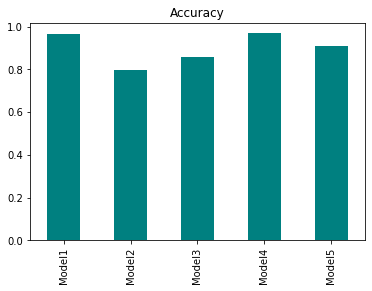

In [54]:
df1['acc'].plot.bar(title = "Accuracy",color="teal")

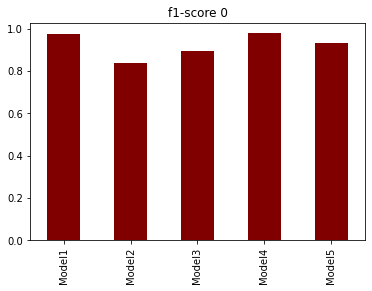

In [55]:
df1['f1_0'].plot.bar(title = "f1-score 0", color = "maroon")

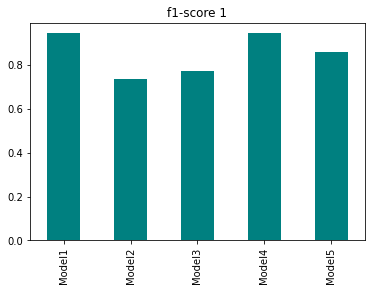

In [56]:
df1['f1_1'].plot.bar(title = "f1-score 1", color = "teal")

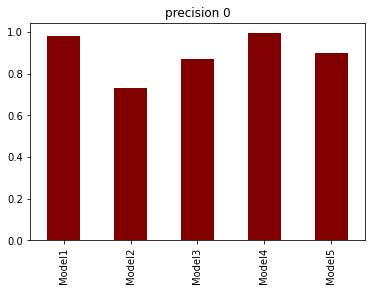

In [57]:
df1['precision_0'].plot.bar(title = "precision 0", color = "maroon")


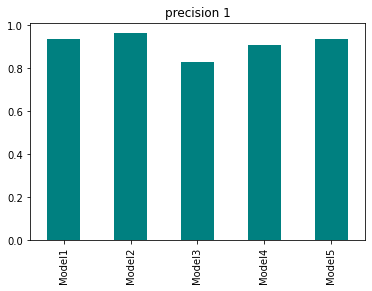

In [58]:
df1['precision_1'].plot.bar(title = "precision 1", color = "teal")

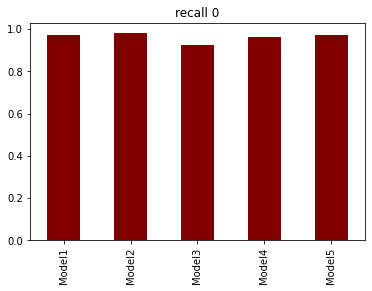

In [59]:
df1['recall_0'].plot.bar(title = "recall 0", color = "maroon")

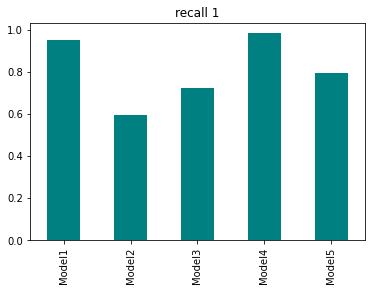

In [60]:
df1['recall_1'].plot.bar(title = "recall 1", color = "teal")

In [ ]:
# axes = df1.plot.bar(
#     rot=0, subplots=True, color={"acc": "red", "f1_1": "green", "f1_0": "orange","precision_1":"teal", "precision_0":"maroon",'recall_0':"yellow", 'recall_1': "blue"}
# )
# # axes[1].legend(loc=7)  

## 4c. Recommended model and reasons

Model 4 is recommended. This is because the model 4 accuracy, f1 for class 0, f1 for class 1, precision for class 0 and recall for class 1 is the highest amongst all the other models. It should also be noted that is has the highest micro average too. Thus model 4 is expected to perform the best when prediciting using the test data set. 

# 5. Evaluation using test set

In [61]:
clean_test_x_join = [" ".join(i) for i in clean_test_x] #turn to string for count_vector 
def report_test(Model):
  predicted = Model.predict(clean_test_x_join)
  return classification_report(predicted,test_y)

print("Model 1")
report1= report_test(Model1)
print(report1)

print("Model 2")
report2 = report_test(Model2)
print(report2)

print("Model 3")
report3= report_test(Model3)
print(report3)

print("Model 4")
report4 = report_test(Model4)
print(report4)

print("Model 5")
report5 = report_test(Model5)
print(report5)

Model 1
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       750
           1       0.92      0.97      0.95       284

    accuracy                           0.97      1034
   macro avg       0.95      0.97      0.96      1034
weighted avg       0.97      0.97      0.97      1034

Model 2
              precision    recall  f1-score   support

           0       0.74      0.98      0.84       557
           1       0.96      0.60      0.74       477

    accuracy                           0.81      1034
   macro avg       0.85      0.79      0.79      1034
weighted avg       0.84      0.81      0.80      1034

Model 3
              precision    recall  f1-score   support

           0       0.88      0.93      0.91       693
           1       0.85      0.74      0.79       341

    accuracy                           0.87      1034
   macro avg       0.86      0.84      0.85      1034
weighted avg       0.87      0.87      0.87      1

## 5b. Is recommendation still valid?

Yes, the recommendation is still valid. Although model 1 and model 4 have the same accuracy score, it does not do better than model 4. 

# 6. Implementation of 1 more variation to improve performance 

### For our improvement we will use n_grams on features used in model 4

In [66]:
#using a bigram 
pipeline6 = Pipeline([
   ('bow',CountVectorizer(ngram_range=(1,2))),
    # ('tfidf',TfidfTransformer()),
    ('classifier',MultinomialNB()),
])

In [68]:
Model6 = pipeline6.fit(not_top100_train_x_join,train_y)

In [71]:
print("Model 6")
report6=report_test(Model6)
print(report6)

Model 6
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       758
           1       0.91      0.99      0.95       276

    accuracy                           0.97      1034
   macro avg       0.95      0.98      0.96      1034
weighted avg       0.97      0.97      0.97      1034



In [94]:
M4 = [0.97,0.98,0.94,0.99,0.90,0.96,0.98,0.94,0.97,0.96]
M6 = [0.97,0.98,0.95,1.00,0.91,0.96,0.99,0.95,0.98,0.96]


index = ['acc', 'f1_0','f1_1', 'precision_0','precision_1', 'recall_0','recall_1','macro_avg p', 'macro_avg r', 'macro_avg f']
df6 = pd.DataFrame({'Model4': M4,
                   'Model6': M6}, index=index)
df6

,Model4,Model6
acc,0.97,0.97
f1_0,0.98,0.98
f1_1,0.94,0.95
precision_0,0.99,1.00
precision_1,0.90,0.91
recall_0,0.96,0.96
recall_1,0.98,0.99
macro_avg p,0.94,0.95
macro_avg r,0.97,0.98
macro_avg f,0.96,0.96


Text(0, 0.5, 'score')

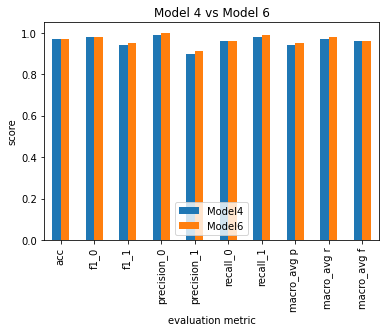

In [95]:
ax = df6.plot.bar(title = "Model 4 vs Model 6")
ax.set_xlabel("evaluation metric")
ax.set_ylabel("score")


Although the accuracy score did not improve, model 6 still managed to improve on a number of other evaluations metrics (slightly). Precision, recal, f1_score and macro average has improved on model 6 by at most 1%. 
